# Librerías que vamos a utilizar

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
import pmdarima as pm

## Lectura del archivo de datos en un dataframe

In [4]:
# Ruta al fichero (cámbiala según tu necesidad)
file_path = './laguna_datos_preprocesados.csv'

# Cargar el fichero en un DataFrame
df = pd.read_csv(file_path)

#Añadimos temperatura media

#df['Tmedia'] = (df['Tmax'] + df['Tmin'])/2

#Mostramos cuantas filas y columnas se han cargado en total
print(f"Se han cargado {df.shape[0]} filas y {df.shape[1]} columnas")
# Mostrar las primeras filas para verificar
print(df.head())

Se han cargado 2113 filas y 5 columnas
   Unnamed: 0                fecha  temperatura   ambiente  nivel
0           0  2023-06-17 00:00:00       31.500  22.000000   51.0
1           1  2023-06-17 01:00:00       31.470  21.780000   51.0
2           2  2023-06-17 02:00:00       31.235  21.201000   47.8
3           3  2023-06-17 03:00:00       31.295  22.439250   52.0
4           4  2023-06-17 04:00:00       31.375  23.058375   50.0


## Visualización de la Serie Temporal

***1. Grafica los datos para observar las fluctuaciones de temperatura a lo largo del tiempo.***

***2. Identifica patrones visuales como tendencia (por ejemplo, aumento gradual de la temperatura a lo largo de los años) y estacionalidad (variaciones cíclicas relacionadas con las estaciones del año).***


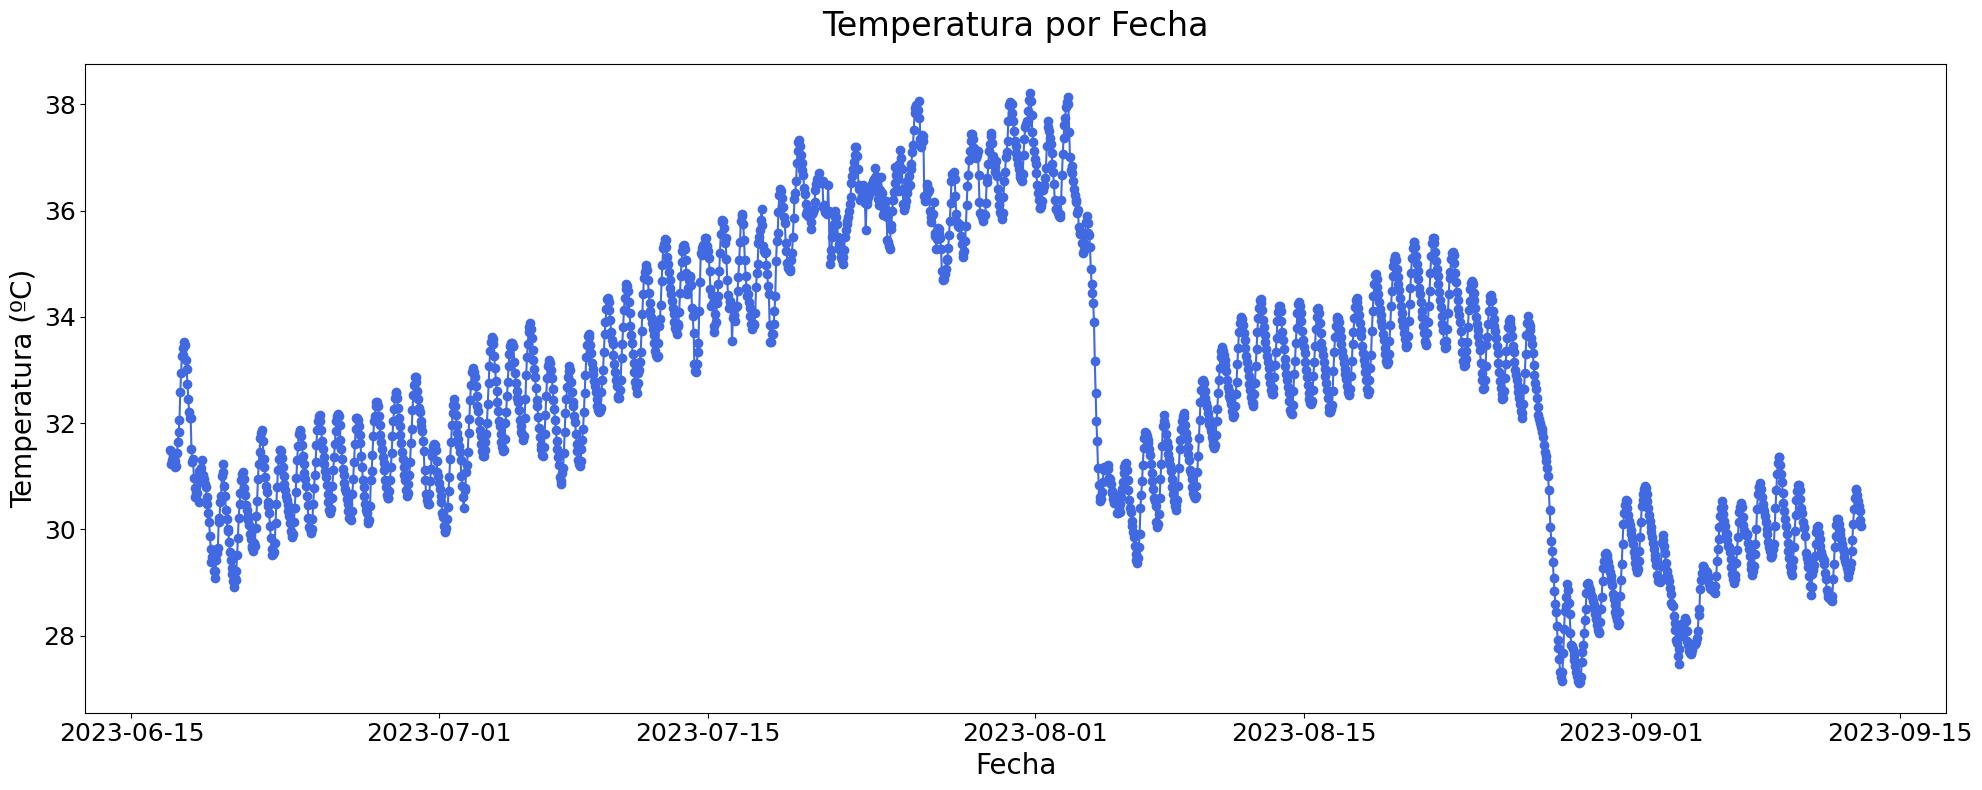

In [5]:
# Asegúrate de que la columna "fecha" esté en formato de fecha
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values('fecha')

# Crear el gráfico
plt.figure(figsize=(20, 8))  # Ajusta el tamaño según lo desees
plt.plot(df['fecha'], df['temperatura'], label='Temperatura laguna', color='royalblue', marker='o')
plt.title('Temperatura por Fecha', fontsize=24, pad= 20)
plt.xlabel('Fecha', fontsize=20)
plt.ylabel('Temperatura (ºC)', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(False)
plt.tight_layout()
plt.show()

## Division de datos

In [6]:
horizonte = 20
train = df['temperatura'].iloc[:-horizonte]
test = df['temperatura'].tail(horizonte)

## Aplicación del Modelo Autorregresivo (AR)

In [7]:
# Aplicamos el modelo AR
modelo_ar = AutoReg(train, lags=1)  # Puedes cambiar el número de lags si es necesario
resultados_ar = modelo_ar.fit()
print(resultados_ar.summary())


                            AutoReg Model Results                             
Dep. Variable:            temperatura   No. Observations:                 2093
Model:                     AutoReg(1)   Log Likelihood                 457.397
Method:               Conditional MLE   S.D. of innovations              0.194
Date:                Mon, 21 Oct 2024   AIC                           -908.795
Time:                        20:47:09   BIC                           -891.857
Sample:                             1   HQIC                          -902.590
                                 2093                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0844      0.055      1.531      0.126      -0.024       0.192
temperatura.L1     0.9974      0.002    593.338      0.000       0.994       1.001
                                    

**Interpretación:**
   
Una vez que hayas ejecutado el modelo, obtendrás un resumen de los resultados. En el resumen, el coeficiente del término `L1.columna_temp` te dará la autocorrelación de primer orden (si utilizaste `lags=1`). Un valor cercano a 1 indica una fuerte autocorrelación positiva, mientras que un valor cercano a -1 indica una fuerte autocorrelación negativa. El valor `P>|z|` te dirá si el coeficiente es estadísticamente significativo.

Ten en cuenta que he asumido que estás usando un retraso (lag) de 1 para el modelo AR. Si quieres usar más retrasos, simplemente cambia el valor en el parámetro `lags` en la función `AutoReg`.

## Evaluación (AR)
***Juega con los lags anteriores para ver si hay algún cambio***

In [8]:
pred = resultados_ar.predict(start=len(train), end=len(train)+19)

mse = mean_squared_error(test, pred)
r2 = r2_score(test, pred)

print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Coeficiente de Determinación R^2: {r2:.2f}")

Error Cuadrático Medio (MSE): 0.51
Coeficiente de Determinación R^2: -0.50


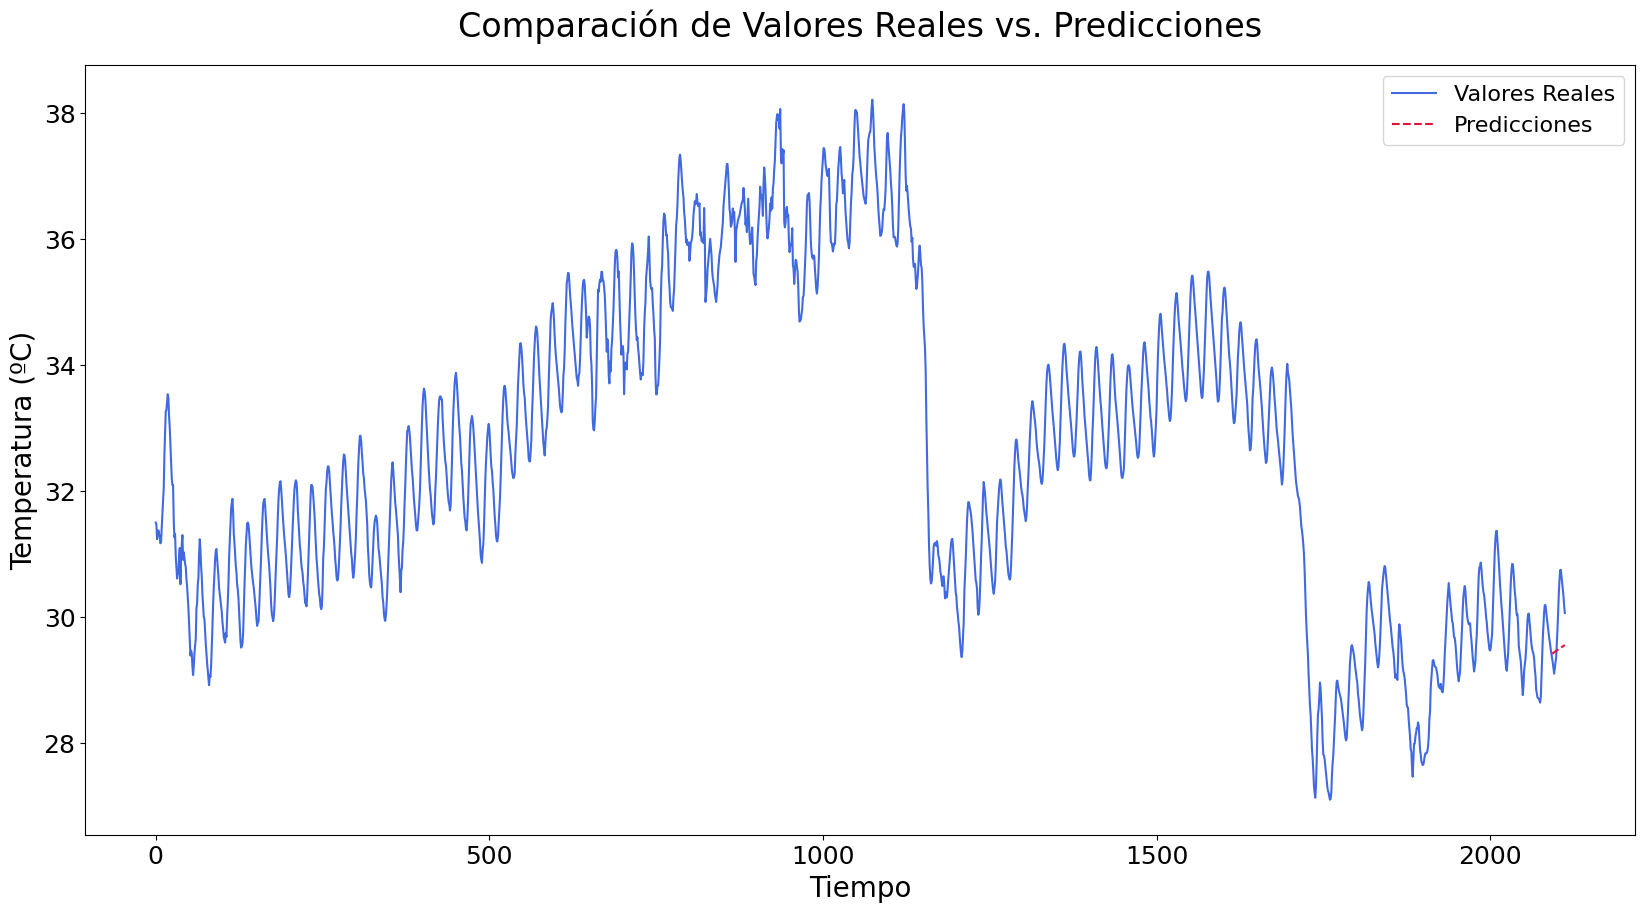

In [9]:
# Tamaño de la figura
plt.figure(figsize=(20,10))

# Graficar los valores reales (test)
full_data = np.concatenate([train, test])

plt.plot(full_data, label='Valores Reales', color='royalblue')

# Graficar las predicciones (pred)
plt.plot(pred, label='Predicciones', color='crimson', linestyle='--')

# Título y etiquetas
plt.legend(fontsize=16)
plt.title('Comparación de Valores Reales vs. Predicciones', fontsize=24, pad = 20)
plt.xlabel('Tiempo', fontsize=20)
plt.ylabel('Temperatura (ºC)', fontsize=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Mostrar la gráfica
plt.show()


## Aplicación del modelo ARIMA

In [11]:
modelARIMA = ARIMA(train, order=(5,1,4))
resultados_arima = modelARIMA.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
predARIMA = resultados_arima.predict(start=len(train), end=len(train)+19, dynamic=False)

## Evaluación (ARIMA)

In [13]:
mse = mean_squared_error(test, predARIMA)
r2 = r2_score(test, predARIMA)

print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Coeficiente de Determinación R^2: {r2:.2f}")

Error Cuadrático Medio (MSE): 0.04
Coeficiente de Determinación R^2: 0.89


## Visualización

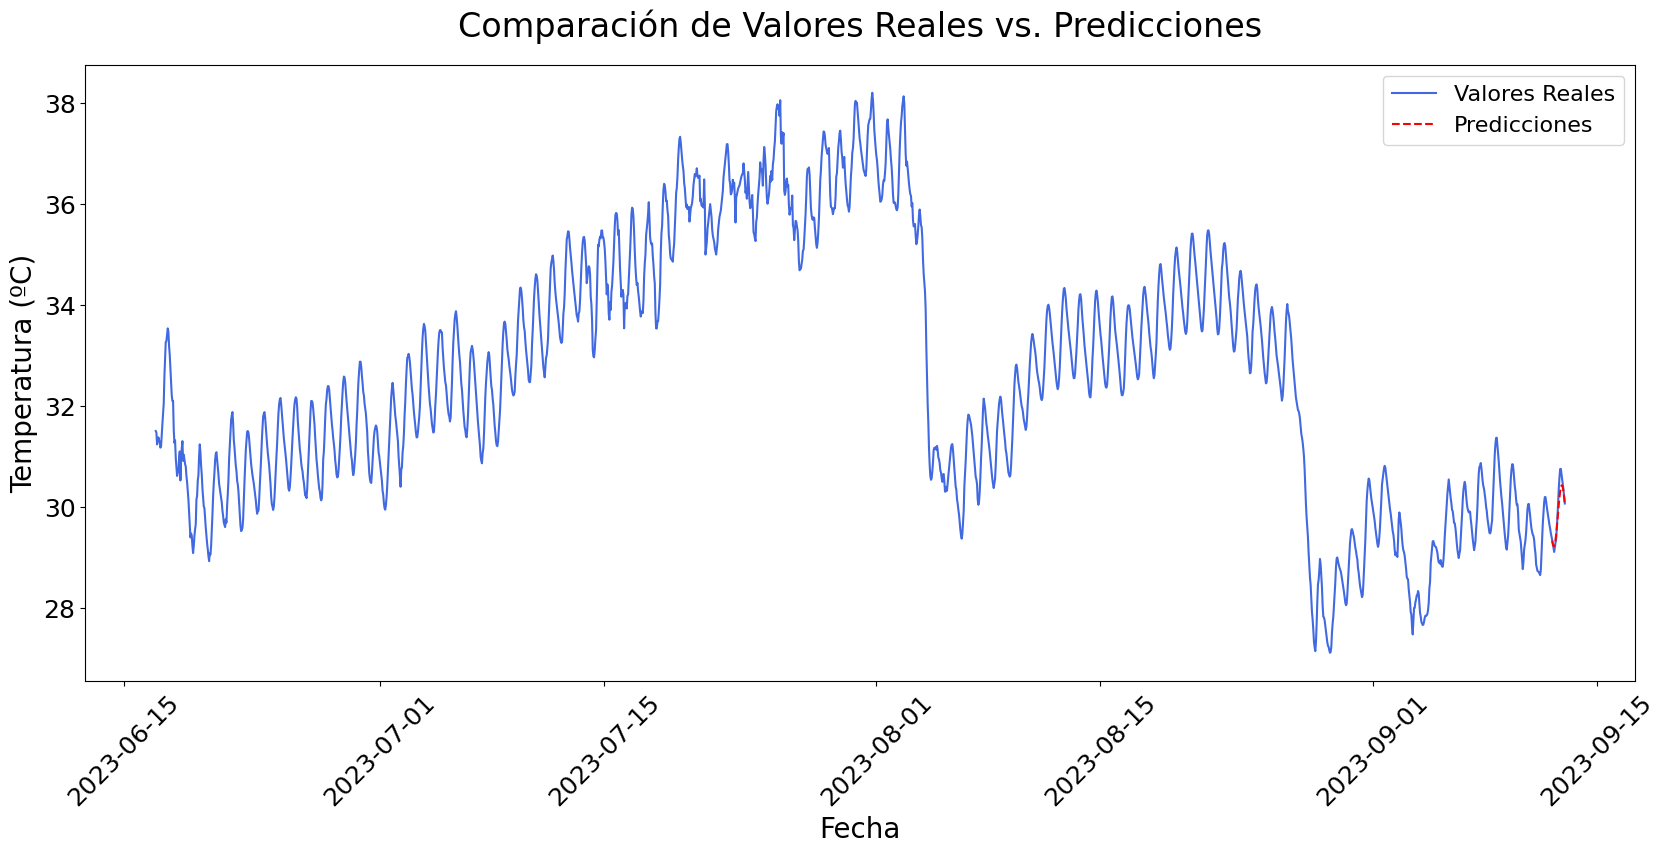

In [14]:
test_dates = df['fecha'].tail(horizonte)
# Tamaño de la figura
plt.figure(figsize=(20,8))

plt.plot(df['fecha'], df['temperatura'], label='Valores Reales', color='royalblue')

# Graficar las predicciones (pred)
plt.plot(test_dates, predARIMA, label='Predicciones', color='red', linestyle='--')

# Título y etiquetas
plt.legend(fontsize=16)
plt.title('Comparación de Valores Reales vs. Predicciones', fontsize=24, pad = 20)
plt.xlabel('Fecha', fontsize=20)
plt.ylabel('Temperatura (ºC)', fontsize=20)
plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18)

# Mostrar la gráfica
plt.show()

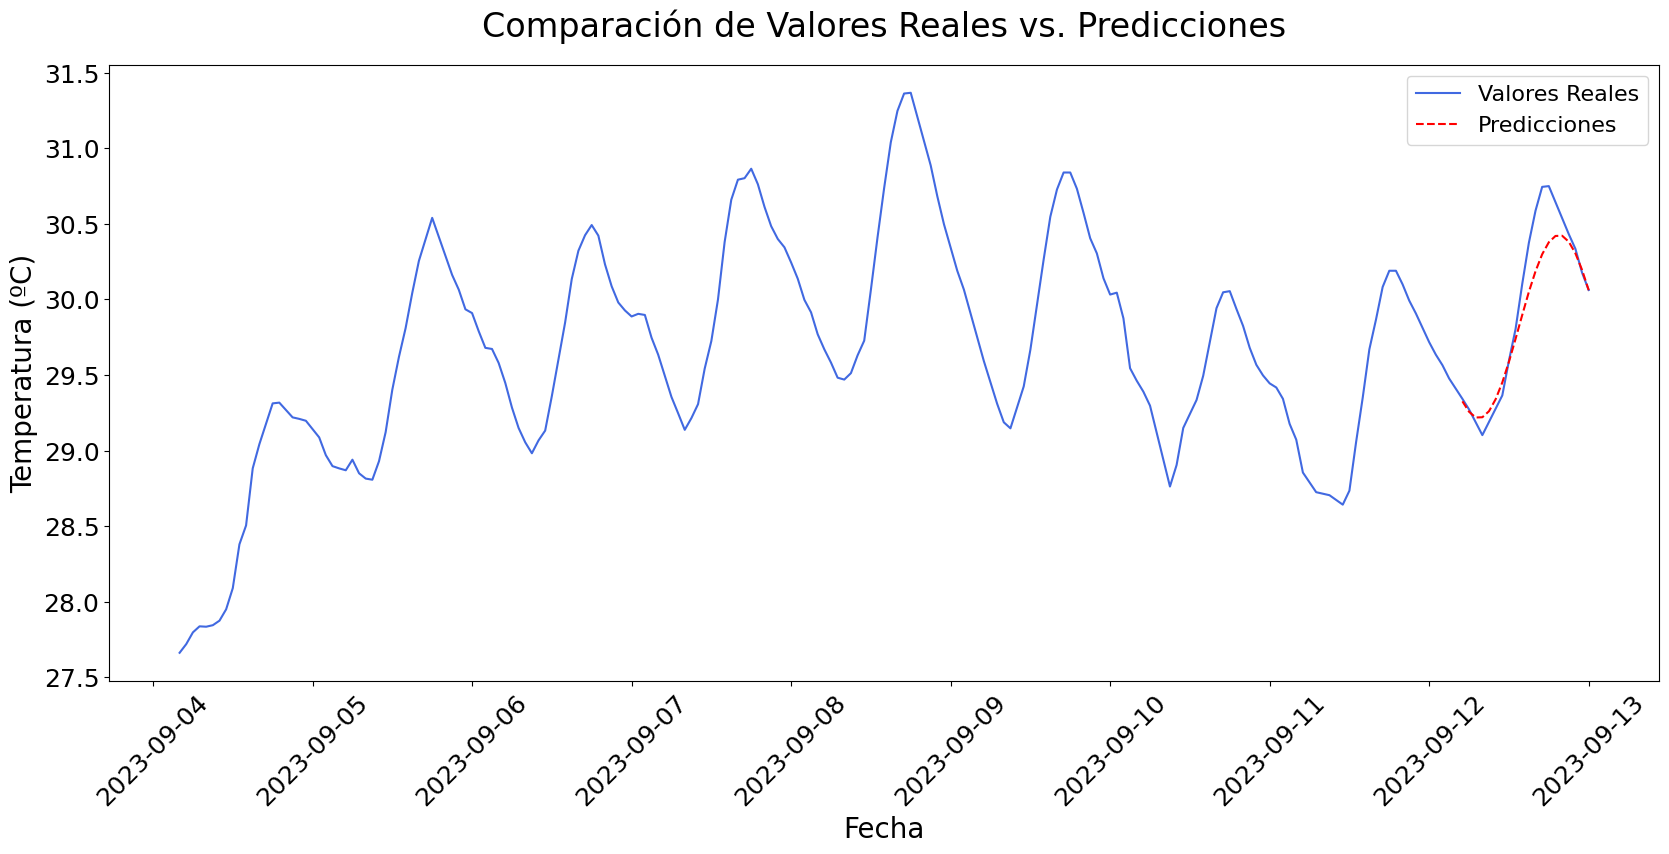

In [15]:
test_dates = df['fecha'].tail(horizonte)
# Tamaño de la figura
plt.figure(figsize=(20,8))

plt.plot(df['fecha'][1900:], df['temperatura'][1900:], label='Valores Reales', color='royalblue')

# Graficar las predicciones (pred)
plt.plot(test_dates, predARIMA, label='Predicciones', color='red', linestyle='--')

# Título y etiquetas
plt.legend(fontsize=16)
plt.title('Comparación de Valores Reales vs. Predicciones', fontsize=24, pad = 20)
plt.xlabel('Fecha', fontsize=20)
plt.ylabel('Temperatura (ºC)', fontsize=20)
plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18)

# Mostrar la gráfica
plt.show()

***El método auto_arima de la biblioteca pmdarima facilita el proceso de ajustar automáticamente los mejores parámetros p, d, y q para un modelo ARIMA. Este proceso es conocido como "grid search" sobre los posibles valores de p, d, y q.***


In [16]:
stepwise_fit = pm.auto_arima(df['temperatura'],
                             trace=True,
                             suppress_warnings=True,
                             seasonal=False)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2583.025, Time=5.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-924.997, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2463.389, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1846.652, Time=1.87 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-926.971, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2492.489, Time=3.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2484.882, Time=9.54 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-2638.221, Time=18.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2674.877, Time=6.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2488.744, Time=1.99 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-2708.057, Time=5.40 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-2512.000, Time=1.62 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-2722.805, Time=9.32 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-2546.011, Time=3.12 sec
 ARIMA(5,1,2)(0,0,0)

In [17]:
print(stepwise_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2113
Model:               SARIMAX(5, 1, 1)   Log Likelihood                1370.251
Date:                Mon, 21 Oct 2024   AIC                          -2726.502
Time:                        20:48:52   BIC                          -2686.914
Sample:                             0   HQIC                         -2712.006
                               - 2113                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3937      0.019     73.122      0.000       1.356       1.431
ar.L2         -0.3378      0.021    -15.756      0.000      -0.380      -0.296
ar.L3         -0.0736      0.020     -3.717      0.0